In [1]:
import sys
import os
sys.path.append(os.getcwd())
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['HOME'] = '/data25/wuqin'
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
print(f"Using device: {device}, dtype: {dtype}")

Using device: cuda, dtype: torch.bfloat16


In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("/data25/wuqin/.cache/huggingface/hub/models--facebook--VGGT-1B/snapshots/860abec7937da0a4c03c41d3c269c366e82abdf9").to(device)

Loading weights from local directory


In [4]:
# 列出所有png图片，并保存其路径到 image_names 列表中
img_dir = 'examples/hall_4f_25'
image_names = [
    os.path.join(img_dir, f)
    for f in os.listdir(img_dir)
    if f.endswith(".jpg")
]
print(image_names[:5])

['examples/hall_4f_25/low1_0.jpg', 'examples/hall_4f_25/low3_0.jpg', 'examples/hall_4f_25/low2_0.jpg', 'examples/hall_4f_25/up5_4.jpg', 'examples/hall_4f_25/low2_6.jpg']


In [5]:
images = load_and_preprocess_images(image_names).to(device)
print(images.shape)

torch.Size([25, 3, 392, 518])


In [6]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)

In [7]:
print(predictions.keys())

dict_keys(['pose_enc', 'pose_enc_list', 'depth', 'depth_conf', 'world_points', 'world_points_conf'])


In [8]:
# camera parameters
print(predictions['pose_enc'].shape)
print(len(predictions['pose_enc_list']), predictions['pose_enc_list'][0].shape)
print(predictions['pose_enc'].min(), predictions['pose_enc'].max())

torch.Size([1, 25, 9])
4 torch.Size([1, 25, 9])
tensor(-1.5122, device='cuda:0') tensor(1.4865, device='cuda:0')


## 深度图

In [9]:
# depth map, conf 为 aleatoric uncertainty
print(predictions['depth'].shape, f"[{predictions['depth'].min().item():.2f}, {predictions['depth'].max().item():.2f}]")
print(predictions['depth_conf'].shape, f"{predictions['depth_conf'].min().item():.2f}, {predictions['depth_conf'].max().item():.2f}]")
print(predictions['depth'].mean().item(), predictions['depth'].std().item())

torch.Size([1, 25, 392, 518, 1]) [0.02, 1.84]
torch.Size([1, 25, 392, 518]) 1.00, 7.63]
0.39451727271080017 0.2362460196018219


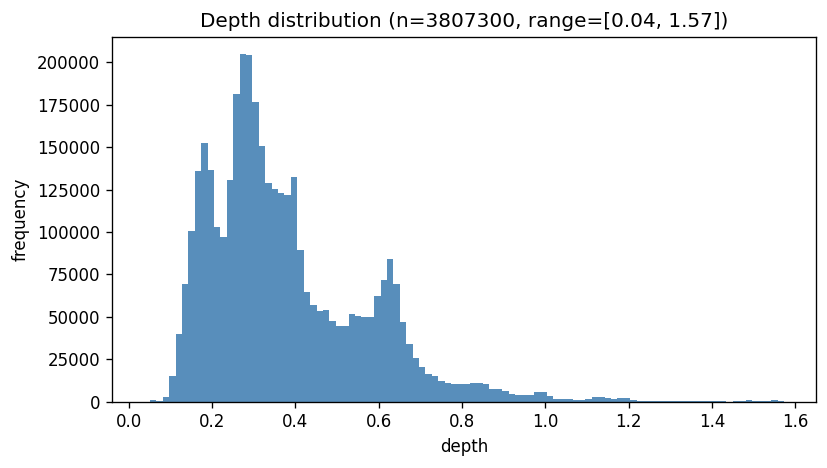

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 统计并绘制深度分布直方图（横轴：深度值，纵轴：频率）
depth = predictions['depth']  # [B, T, H, W, 1]
if depth.dim() == 5 and depth.size(-1) == 1:
    depth = depth.squeeze(-1)  # -> [B, T, H, W]

# 拉平并过滤无效/非正值
depth_conf_percent = 25
conf_flat = predictions['depth_conf'].reshape(-1).cpu().numpy().astype(np.float32)
idx_all = np.arange(conf_flat.shape[0])
if conf_flat.size > 0:
    threshold_val = np.percentile(conf_flat, depth_conf_percent)
else:
    threshold_val = 0.0
keep = (conf_flat >= threshold_val) & (conf_flat > 1e-5)
idx_keep = idx_all[keep]
depth_np = depth.reshape(-1).cpu().numpy()[keep]

bins = 100
_dmin, _dmax = depth_np.min(), depth_np.max()

plt.figure(figsize=(7, 4), dpi=120)
plt.hist(depth_np, bins=bins, range=(_dmin, _dmax), color='steelblue', alpha=0.9)
plt.xlabel('depth')
plt.ylabel('frequency')
plt.title(f'Depth distribution (n={depth_np.size}, range=[{_dmin:.2f}, {_dmax:.2f}])')
plt.tight_layout()
plt.show()

In [13]:
print(depth_np.mean(), depth_np.std())

0.3795328 0.19304843


## 点云

In [11]:
# point map
print(predictions['world_points'].shape)
print(predictions['world_points_conf'].shape, f"[{predictions['world_points_conf'].min().item():.2f}, {predictions['world_points_conf'].max().item():.2f}]")
print(predictions['world_points'][0][0][0][0])

torch.Size([1, 25, 392, 518, 3])
torch.Size([1, 25, 392, 518]) [1.00, 8.92]
tensor([-0.0940, -0.0681,  0.1031], device='cuda:0')


In [ ]:
# 相机内外参获取
# 转换为 4x4 齐次矩阵
def to_homogeneous(extrinsics):
    batch, seq = extrinsics.shape[:2]
    last_row = torch.tensor([0, 0, 0, 1], device=extrinsics.device).reshape(1, 1, 1, 4)
    last_row = last_row.expand(batch, seq, -1, -1)
    return torch.cat([extrinsics, last_row], dim=2)
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
extrinsics, intrinsics = pose_encoding_to_extri_intri(predictions['pose_enc'], predictions['depth_conf'].shape[2:4])
print(extrinsics.shape, intrinsics.shape)
print(to_homogeneous(extrinsics).shape) # 外参变为 4x4 形式

torch.Size([1, 25, 3, 4]) torch.Size([1, 25, 3, 3])
torch.Size([1, 25, 4, 4])
